Welcome to the 30 minutes Flower federated learning tutorial!

In this tutorial you will implement your first Federated Learning project using [Flower](https://flower.ai/).

🧑‍🏫 This tutorial starts at zero and expects no familiarity with federated learning. Only a basic understanding of data science and Python programming is assumed. A minimal understanding of ML is not required but if you already know about it, nothing is stopping your from modifying this code as you see fit!

> Star Flower on [GitHub ⭐️](https://github.com/adap/flower) and join the Flower community on Slack to connect, ask questions, and get help: [Join Slack 🌼](https://flower.ai/join-slack/). We'd love to hear from you in the #introductions channel! And if anything is unclear, head over to the #questions channel.

Let's get started!

## Complementary Content

But before do so, let me point you to a few video tutorials in the [Flower Youtube channel](https://www.youtube.com/@flowerlabs) that you might want to check out after this tutorial. We post new videos fairly regularly with new content:
* **[VIDEO]** quickstart-tensorflow: [15-min video on how to start with Flower + Tensorflow/Keras](https://www.youtube.com/watch?v=FGTc2TQq7VM)
* **[VIDEO]** quickstart-pytorch: [20-min video on how to start with Flower + PyTorch](https://www.youtube.com/watch?v=jOmmuzMIQ4c)
* **[VIDEO]**  Flower simulation mini-series: [9 line-by-line video tutorials](https://www.youtube.com/watch?v=cRebUIGB5RU&list=PLNG4feLHqCWlnj8a_E1A_n5zr2-8pafTB)

# Centralised training: the old way of doing ML

Let's begin by creating a simple (but complete) training loop as it is commonly done in centralised setups. Starting our tutorial in this way will allow us to very clearly identify which parts of a typical ML pipeline are common to both centralised and federated training and which ones are poles a part.

For this tutorial we'll design a image classification pipeline for [MNIST digits](https://en.wikipedia.org/wiki/MNIST_database) and using a simple CNN model as the network to train. The MNIST dataset is comprised of `28x28` greyscale images with digits from 0 to 9 (i.e. 10 classes in total)


## A dataset

Let's begin by constructing the dataset.

In [3]:
import torch
from torch.utils.data import Dataset
import numpy as np

class ReutersDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = torch.tensor(self.data[idx], dtype=torch.long)  # Long tensor for embedding
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Long tensor for target labels
        return data, label

In [5]:

from tensorflow.keras.datasets import reuters

def get_reuters():
    # Load Reuters dataset
    (X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=40000, maxlen=50, test_split=0.2)

    # Create Dataset instances
    trainset = ReutersDataset(X_train, y_train)
    testset = ReutersDataset(X_test, y_test)
    return trainset, testset

Let's run the code above and do some visualisations to understand better the data we are working with !

In [6]:
trainset, testset = get_reuters()

Let's create a more insightful visualisation. First let's see the distribution over the labels by constructing a histogram. Then, let's visualise some training examples !

(ClientAppActor pid=6139) /Users/maxkleinegger/miniconda3/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(ClientAppActor pid=6139)   warnings.warn('resource_tracker: There appear to be %d '


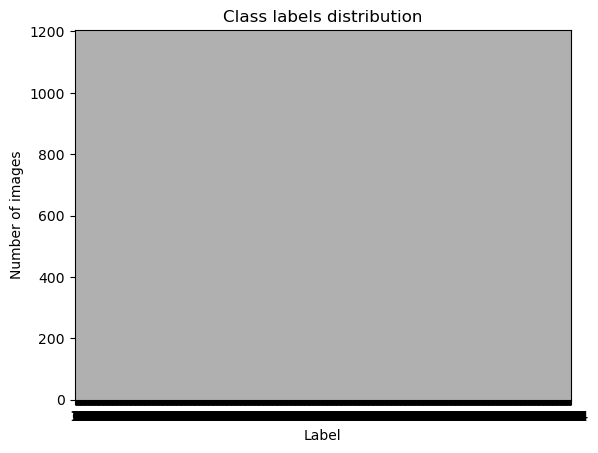

In [36]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

# Extract all labels from the trainset
all_labels = [label for _, label in trainset]

# Count unique labels
num_possible_labels = len(set(all_labels))

# Construct histogram
plt.hist(all_labels, bins=num_possible_labels, edgecolor='black')

# Plot formatting
plt.xticks(range(num_possible_labels))
plt.grid()
plt.xlabel("Label")
plt.ylabel("Number of images")
plt.title("Class labels distribution")
plt.show()

Let's visualise 32 images from the dataset


# A CNN architecture

This tutorial is not so much about novel architectural designs so we keep things simple and make use of a typical CNN that is adequate for the MNIST image classification task.



In [9]:
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        x = self.embedding(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

Similarly to what we did with the dataset you could inspect the model in various ways. We can, for instance, count the number of model parameters.

In [10]:
model = LSTM(input_size=40000, hidden_size=50, num_layers=2, num_classes=46)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 2043146


## The Training Loop

A minimal training loop in PyTorch can be constructed with three functions:
*  `train()` that will train the model given a dataloader.
* `test()` that will be used to evaluate the performance of the model on held-out data, e.g., a training set.
* `run_centralised()` which will define additional elements (e.g. the optimiser) and run the training loop over N epochs.

Let's construct these functions!


Let's run this for 5 epochs (you'll see it reaching close to 99% accuracy -- as expected from a centralised setup with the MNIST dataset)

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

def collate_fn(batch):
    data, labels = zip(*batch)
    data_padded = pad_sequence(data, batch_first=True)
    labels = torch.tensor(labels)
    return data_padded, labels

def train(model, trainloader, optimizer, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    model.train()
    for _ in tqdm(range(epochs)):
        for text, labels in trainloader:
            optimizer.zero_grad()
            loss = criterion(model(text), labels)
            loss.backward()
            optimizer.step()
    return model

def test(model, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    model.eval()
    with torch.no_grad():
        for text, labels in testloader:
            outputs = model(text)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy


def run_centralised(epochs: int, lr: float, momentum: float = 0.9):
    model = LSTM(input_size=40000, hidden_size=50, num_layers=2, num_classes=46)
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=collate_fn)
    testloader = DataLoader(testset, batch_size=128, collate_fn=collate_fn)

    trained_model = train(model, trainloader, optim, epochs)
    loss, accuracy = test(trained_model, testloader)
    print(f"{loss = }")
    print(f"{accuracy = }")

run_centralised(epochs=10, lr=0.01)

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

loss = 5.24511981010437
accuracy = 0.7468671679197995


The above centralised formulation has worked just fine for some applications and to showcase the potential of AI in a variety of scenarios. However, as was discussed earlier in the session, centralised training is unsuitable for a larger range of settings were information cannot be collected in order to build a unified (centralised) dataset.

# The Future of AI is Federated

What are the key differences between Federated Learning and Centralised Training? I you could only pick you, probably you'd say:
* Federated Learning is distributed -- the model is trained on-device by the participating clients.
* Data remains private and is owned by a specific _client_ -- the data is never sent to the central server.

The are several more differences. But the above two are the main ones to always consider and that are common to all flavours of Federated Learning (e.g. _cross-device_ or _cross-silo_). The remaining of this tutorial is going to focus in transforming the code we have written so far for the centralised setting and construct a Federated Learning pipeline using Flower and PyTorch.

Let's begin! 🚀

## One Client, One Data Partition

To start designing a Federated Learning pipeline we need to meet one of the key properties in FL: each client has its own data partition. To accomplish this with the MNIST dataset, we are going to generate N random partitions, where N is the total number of clients in our FL system.

In [27]:
num_clients = 10

In [28]:
from torch.utils.data import DataLoader, random_split

def prepare_dataset(num_partitions: int, batch_size: int, val_ratio: float = 0.1):
    """This function partitions the training set into N disjoint
    subsets, each will become the local dataset of a client. This
    function also subsequently partitions each traininset partition
    into train and validation. The test set is left intact and will
    be used by the central server to assess the performance of the
    global model."""

    # split trainset into `num_partitions` trainsets
    num_images = len(trainset)
    partition_len = [num_images // num_partitions] * num_partitions
    partition_len[-1] += num_images % num_partitions  # Add remainder to the last partition

    trainsets = random_split(trainset, partition_len, torch.Generator().manual_seed(2023))

    # create dataloaders with train+val support
    trainloaders = []
    valloaders = []
    for trainset_ in trainsets:
        num_total = len(trainset_)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        for_train, for_val = random_split(trainset_, [num_train, num_val], torch.Generator().manual_seed(2023))

        trainloaders.append(DataLoader(for_train, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn))
        valloaders.append(DataLoader(for_val, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn))

    # create dataloader for the test set
    testloader = DataLoader(testset, batch_size=128, collate_fn=collate_fn)

    return trainloaders, valloaders, testloader

Let's create 100 partitions and extract some statistics from one partition


number of images: 144


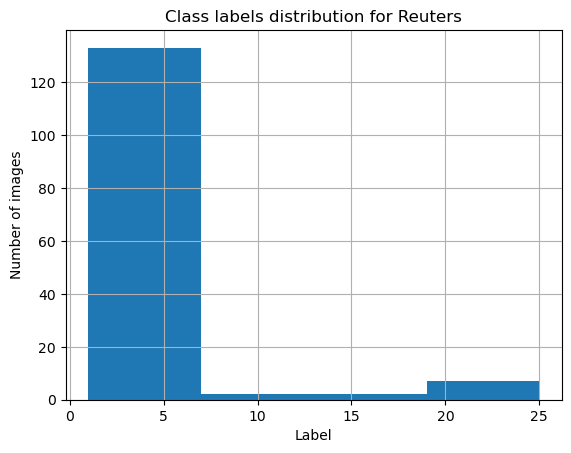

In [29]:
import matplotlib.pyplot as plt
trainloaders, valloaders, testloader = prepare_dataset(num_partitions=num_clients, batch_size=8)

# first partition
train_partition = trainloaders[1].dataset

# count data points
partition_indices = train_partition.indices
print(f"number of images: {len(partition_indices)}")

# visualise histogram
plt.hist([train_partition.dataset[idx][1].item() for idx in partition_indices], bins=4)  # 46 classes in Reuters dataset
plt.grid()
plt.xlabel("Label")
plt.ylabel("Number of images")
plt.title("Class labels distribution for Reuters")
plt.show()

As you can see, the histogram of this partition is a bit different from the one we obtained at the beginning where we took the entire dataset into consideration. Because our data partitions are artificially constructed by sampling the MNIST dataset in an IID fashion, our Federated Learning example will not face sever _data heterogeneity_ issues (which is a fairly [active research topic](https://arxiv.org/abs/1912.04977)).

Let's next define how our FL clients will behave

## Defining a Flower Client

You can think of a client in FL as an entity that owns some data and trains a model using this data. The caveat is that the model is being trained _collaboratively_ in Federation by multiple clients (sometimes up to hundreds of thousands) and, in most instances of FL, is sent by a central server.

A Flower Client is a simple Python class with four distinct methods:

* `fit()`: With this method, the client does on-device training for a number of epochs using its own data. At the end, the resulting model is sent back to the server for aggregation.

* `evaluate()`: With this method, the server can evaluate the performance of the global model on the local validation set of a client. This can be used for instance when there is no centralised dataset on the server for validation/test. Also, this method can be use to asses the degree of personalisation of the model being federated.

* `set_parameters()`: This method takes the parameters sent by the server and uses them to initialise the parameters of the local model that is ML framework specific (e.g. TF, Pytorch, etc).

* `get_parameters()`: It extract the parameters from the local model and transforms them into a list of NumPy arrays. This ML framework-agnostic representation of the model will be sent to the server.

Let's start by importing Flower!

In [30]:
import flwr as fl

Now let's define our Flower Client class:

In [31]:
from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.model = LSTM(input_size=40000, hidden_size=50, num_layers=2, num_classes=46)

    def set_parameters(self, parameters):
        """With the model parameters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and convert them to a list of
        NumPy arrays. The server doesn't work with PyTorch/TF/etc."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)

        # Define the optimizer -------------------------------------------------------------- Essentially the same as in the centralised example above
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # do local training  -------------------------------------------------------------- Essentially the same as in the centralised example above (but now using the client's data instead of the whole dataset)
        train(self.model, self.trainloader, optim, epochs=1)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(
            self.model, self.valloader
        )  # <-------------------------- calls the `test` function, just what we did in the centralised setting (but this time using the client's local validation set)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}

Spend a few minutes to inspect the `FlowerClient` class above. Please ask questions if there is something unclear !

Then keen-eyed among you might have realised that if we were to fuse the client's `fit()` and `evaluate()` methods, we'll end up with essentially the same as in the `run_centralised()` function we used in the Centralised Training part of this tutorial. And it is true!! In Federated Learning, the way clients perform local training makes use of the same principles as more traditional centralised setup. The key difference is that the dataset now is much smaller and it's never _"seen"_ by the entity running the FL workload (i.e. the central server).


Talking about the central server... we should define what strategy we want to make use of so the updated models sent from the clients back to the server at the end of the `fit()` method are aggregate.


## Chosing a Flower Strategy


A strategy sits at the core of the Federated Learning experiment. It is involved in all stages of a FL pipeline: sampling clients; sending the _global model_ to the clients so they can do `fit()`; receive the updated models from the clients and **aggregate** these to construct a new _global model_; define and execute global or federated evaluation; and more.

Flower comes with [many strategies built-in](https://github.com/adap/flower/tree/main/src/py/flwr/server/strategy) and more to be available in the next release (`1.5` already!). For this tutorial, let's use what is arguable the most popular strategy out there: `FedAvg`.

The way `FedAvg` works is simple but performs surprisingly well in practice. It is therefore one good strategy to start your experimentation. `FedAvg`, as its name implies, derives a new version of the _global model_ by taking the average of all the models sent by clients participating in the round. You can read all the details [in the paper](https://arxiv.org/abs/1602.05629).

Let's see how we can define `FedAvg` using Flower. We use one of the callbacks called `evaluate_fn` so we can easily evaluate the state of the global model using a small centralised testset. Note this functionality is user-defined since it requires a choice in terms of ML-framework. (if you recall, Flower is framework agnostic).

> This being said, centralised evaluation of the global model is only possible if there exists a centralised dataset that somewhat follows a similar distribution as the data that's spread across clients. In some cases having such centralised dataset for validation is not possible, so the only solution is to federate the evaluation of the _global model_. This is the default behaviour in Flower. If you don't specify teh `evaluate_fn` argument in your strategy, then, centralised global evaluation won't be performed.

In [32]:
def get_evaluate_fn(testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = LSTM(input_size=40000, hidden_size=50, num_layers=2, num_classes=46)

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test
        loss, accuracy = test(
            model, testloader
        )  # <-------------------------- calls the `test` function, just what we did in the centralised setting
        return loss, {"accuracy": accuracy}

    return evaluate_fn


# now we can define the strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,  # let's sample 10% of the client each round to do local training
    fraction_evaluate=0.2,  # after each round, let's sample 20% of the clients to asses how well the global model is doing
    min_available_clients=num_clients,  # total number of clients available in the experiment
    evaluate_fn=get_evaluate_fn(testloader),
)  # a callback to a function that the strategy can execute to evaluate the state of the global model on a centralised dataset

So far we have:
* created the dataset partitions (one for each client)
* defined the client class
* decided on a strategy to use

Now we just need to launch the Flower FL experiment... not so fast! just one final function: let's create another callback that the Simulation Engine will use in order to span VirtualClients. As you can see this is really simple: construct a FlowerClient object, assigning each their own data partition.

In [33]:
def generate_client_fn(trainloaders, valloaders):
    def client_fn(cid: str):
        """Returns a FlowerClient containing the cid-th data partition"""

        return FlowerClient(
            trainloader=trainloaders[int(cid)], valloader=valloaders[int(cid)]
        ).to_client()

    return client_fn


client_fn_callback = generate_client_fn(trainloaders, valloaders)

Now we are ready to launch the FL experiment using Flower simulation:

In [34]:
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=num_clients,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=10),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout


2024-07-25 19:51:59,682	INFO worker.py:1724 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 8708920116.0, 'node:__internal_head__': 1.0, 'CPU': 10.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 10 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=6139) /Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
(pid=6139)   from pandas.core import (
(ClientAppActor pid=6148) /Users/max

Doing 10 rounds should take less than 2 minutes on a CPU-only Colab instance <-- Flower Simulation is fast! 🚀

You can then use the returned `History` object to either save the results to disk or do some visualisation (or both of course, or neither if you like chaos). Below you can see how you can plot the centralised accuracy obtained at the end of each round (including at the very beginning of the experiment) for the _global model_. This is want the function `evaluate_fn()` that we passed to the strategy reports.

history.metrics_centralized = {'accuracy': [(0, 0.002506265664160401), (1, 0.7468671679197995), (2, 0.7468671679197995), (3, 0.7468671679197995), (4, 0.7468671679197995), (5, 0.7468671679197995), (6, 0.7468671679197995), (7, 0.7468671679197995), (8, 0.7468671679197995), (9, 0.7468671679197995), (10, 0.7468671679197995)]}


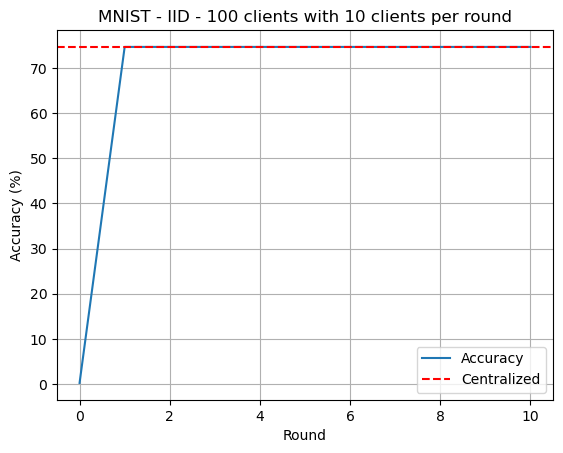

In [35]:
# Assuming `history.metrics_centralized` contains the data as described
print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
rounds = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]

plt.plot(rounds, acc, label='Accuracy')
plt.axhline(y=74.69, color='r', linestyle='--', label='Centralized')
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 100 clients with 10 clients per round")
plt.legend()

plt.show()

## What's next?

Well, if you enjoyed this content, consider giving us a ⭐️ on GitHub -> https://github.com/adap/flower

* **[DOCS]** How about running your Flower clients on the GPU? find out how to do it in the [Flower Simulation Documentation](https://flower.ai/docs/framework/how-to-run-simulations.html)

* **[VIDEO]** You can follow our [detailed line-by-line 9-videos tutorial](https://www.youtube.com/watch?v=cRebUIGB5RU&list=PLNG4feLHqCWlnj8a_E1A_n5zr2-8pafTB) about everything you need to know to design your own Flower Simulation pipelines

* Check more advanced simulation examples the Flower GitHub:

    * Flower simulation with Tensorflow/Keras: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/adap/flower/tree/main/examples/simulation-tensorflow)

    * Flower simulation with Pytorch: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/adap/flower/tree/main/examples/simulation-pytorch)

* **[DOCS]** All Flower examples: https://flower.ai/docs/examples/

* **[VIDEO]** Our Youtube channel: https://www.youtube.com/@flowerlabs

Don't forget to join our Slack channel: https://flower.ai/join-slack/


## What's next?

Well, if you enjoyed this content, consider giving us a ⭐️ on GitHub -> https://github.com/adap/flower

* **[DOCS]** How about running your Flower clients on the GPU? find out how to do it in the [Flower Simulation Documentation](https://flower.ai/docs/framework/how-to-run-simulations.html)

* **[VIDEO]** You can follow our [detailed line-by-line 9-videos tutorial](https://www.youtube.com/watch?v=cRebUIGB5RU&list=PLNG4feLHqCWlnj8a_E1A_n5zr2-8pafTB) about everything you need to know to design your own Flower Simulation pipelines

* Check more advanced simulation examples the Flower GitHub:

    * Flower simulation with Tensorflow/Keras: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/adap/flower/tree/main/examples/simulation-tensorflow)

    * Flower simulation with Pytorch: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/adap/flower/tree/main/examples/simulation-pytorch)

* **[DOCS]** All Flower examples: https://flower.ai/docs/examples/

* **[VIDEO]** Our Youtube channel: https://www.youtube.com/@flowerlabs

Don't forget to join our Slack channel: https://flower.ai/join-slack/
